### Import Dependencies

In [29]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import cv2
from skimage.color import rgb2gray
from PIL import Image


In [30]:
torch.cuda.is_available()

True

### Import Datasets and Get Classes

In [31]:
for dirpath, dirnames, filenames in os.walk("data"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

letter_class = len(os.listdir("data/train"))

dataset_dir = pathlib.Path("data/train")
class_names = np.array(sorted([item.name for item in dataset_dir.glob("*")]))
print(class_names)

There are 3 directories and 0 images in data
There are 36 directories and 0 images in data\test
There are 0 directories and 157 images in data\test\0
There are 0 directories and 159 images in data\test\1
There are 0 directories and 155 images in data\test\2
There are 0 directories and 156 images in data\test\3
There are 0 directories and 155 images in data\test\4
There are 0 directories and 156 images in data\test\5
There are 0 directories and 156 images in data\test\6
There are 0 directories and 155 images in data\test\7
There are 0 directories and 155 images in data\test\8
There are 0 directories and 155 images in data\test\9
There are 0 directories and 153 images in data\test\A
There are 0 directories and 155 images in data\test\B
There are 0 directories and 154 images in data\test\C
There are 0 directories and 152 images in data\test\D
There are 0 directories and 152 images in data\test\E
There are 0 directories and 153 images in data\test\F
There are 0 directories and 153 images i

### Data Preprocessing

##### Call the dataset

In [32]:
resize_transform = transforms.Compose([
    transforms.Resize((256, 256)),
])

image_dataset = datasets.ImageFolder(root='data/train/',transform=resize_transform)

##### Show image example in each class

In [33]:
# # Define the classes of your dataset
# classes = image_dataset.classes

# # Create a figure with subplots for each class
# fig, axes = plt.subplots(6, 6, figsize=(12, 12))

# # Loop through each class and plot the first image
# for i, cls in enumerate(classes):
#     # Get the indices of the images for this class
#     indices = [j for j, (x, y) in enumerate(image_dataset) if y == i]
#     # Get the first image for this class
#     img = image_dataset[indices[0]][0]
#     img = img.resize((256, 256))
#     # Plot the image on the corresponding subplot
#     axes.flat[i].imshow(img)
#     axes.flat[i].set_title(cls)

# plt.show()

##### Create image preprocessing

In [34]:
# class OtsuTransform:
#     def __call__(self, image):
#         # Convert the PIL Image to a NumPy array
#         image_array = np.array(image)
        
#         # Convert the image to grayscale
#         gray_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
        
#         # Convert the grayscale image to the desired format (8-bit or 16-bit)
#         if gray_image.dtype != np.uint8:
#             gray_image = (gray_image * 255).astype(np.uint8)
        
#         # Apply Otsu's thresholding
#         _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
#         # Convert the binary image back to a PIL Image
#         binary_image = Image.fromarray(binary_image)
        
#         # Return the binary image
#         return binary_image

In [35]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize( [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

##### Show image transformation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


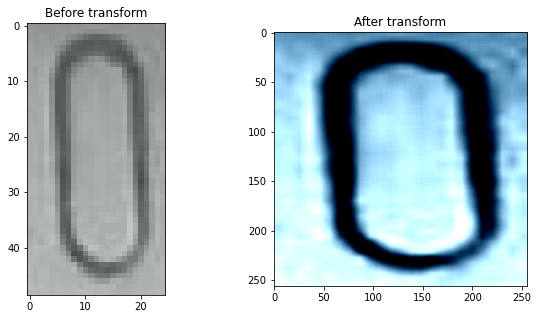

In [36]:
image_dataset = datasets.ImageFolder(root='data/train/')

example_image, _ = image_dataset[0]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(example_image)
ax[0].set_title('Before transform')
transformed_image = transform(example_image)
ax[1].imshow(transformed_image.permute(1, 2, 0))
ax[1].set_title('After transform')
plt.show()

### AlexNet Model Building

##### Hyperparameter Setup

In [37]:
num_classes = 36
batch_size = 64
num_epochs = 64
learning_rate = 0.0001

##### Apply preprocessing to transform the dataset

In [38]:
train_set = datasets.ImageFolder(root='data/train/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

val_set = datasets.ImageFolder(root='data/val/', transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = datasets.ImageFolder(root='data/test/', transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

##### Load pre-trained AlexNet model

In [39]:
model = models.alexnet(pretrained=True)
# Modify the first convolutional layer to accept 1 channel instead of 3
# model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)

In [40]:
# Freeze all layers in the pre-trained model
for param in model.parameters():
    param.requires_grad = False

In [41]:
# Replace the last fully connected layer with a new one
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

##### Define loss function and optimizer

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Train and Validate Model

##### Train the model

In [43]:
# Train the model
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Iterate over the validation dataset in batches
train_predictions = np.array([])
train_ground_truths = np.array([])

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()
        # images = images.cpu()
        # labels = labels.cpu()
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
    train_losses.append(train_loss/train_total)
    train_accs.append(train_correct/train_total)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            labels = labels.cuda()
            # images = images.cpu()
            # labels = labels.cpu()
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            train_predictions = np.concatenate((train_predictions, predicted.cpu().numpy()))
            train_ground_truths = np.concatenate((train_ground_truths, labels.cpu().numpy()))

            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
        
        # remove the extra predictions
        if len(train_predictions) > len(train_ground_truths):
            train_predictions = train_predictions[:len(train_ground_truths)]

    # Convert predictions and true labels to numpy arrays
    train_predictions = np.array(train_predictions)
    train_ground_truths = np.array(train_ground_truths)
    
    val_losses.append(val_loss/val_total)
    val_accs.append(val_correct/val_total)
    
    # Print epoch statistics
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
          .format(epoch+1, num_epochs, train_losses[-1], train_accs[-1], val_losses[-1], val_accs[-1]))

Epoch [1/64], Train Loss: 1.5563, Train Acc: 0.7115, Val Loss: 0.7273, Val Acc: 0.9237
Epoch [2/64], Train Loss: 0.5747, Train Acc: 0.9176, Val Loss: 0.3849, Val Acc: 0.9605
Epoch [3/64], Train Loss: 0.3711, Train Acc: 0.9469, Val Loss: 0.2579, Val Acc: 0.9737
Epoch [4/64], Train Loss: 0.2765, Train Acc: 0.9594, Val Loss: 0.1901, Val Acc: 0.9812
Epoch [5/64], Train Loss: 0.2201, Train Acc: 0.9677, Val Loss: 0.1494, Val Acc: 0.9850
Epoch [6/64], Train Loss: 0.1890, Train Acc: 0.9698, Val Loss: 0.1225, Val Acc: 0.9864
Epoch [7/64], Train Loss: 0.1622, Train Acc: 0.9739, Val Loss: 0.1008, Val Acc: 0.9894
Epoch [8/64], Train Loss: 0.1435, Train Acc: 0.9766, Val Loss: 0.0866, Val Acc: 0.9902
Epoch [9/64], Train Loss: 0.1234, Train Acc: 0.9796, Val Loss: 0.0742, Val Acc: 0.9934
Epoch [10/64], Train Loss: 0.1131, Train Acc: 0.9813, Val Loss: 0.0647, Val Acc: 0.9939
Epoch [11/64], Train Loss: 0.1029, Train Acc: 0.9820, Val Loss: 0.0582, Val Acc: 0.9938
Epoch [12/64], Train Loss: 0.0943, Train 

##### Plot losses and accuracy

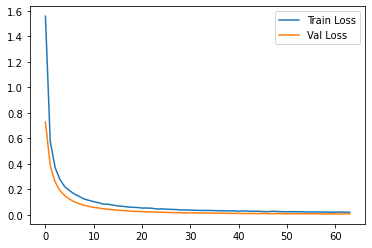

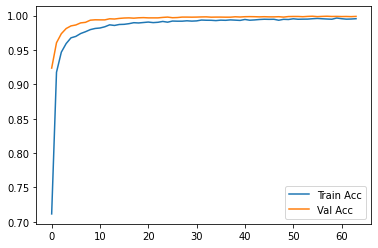

In [44]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.show()

##### Calculate the confusion matrix

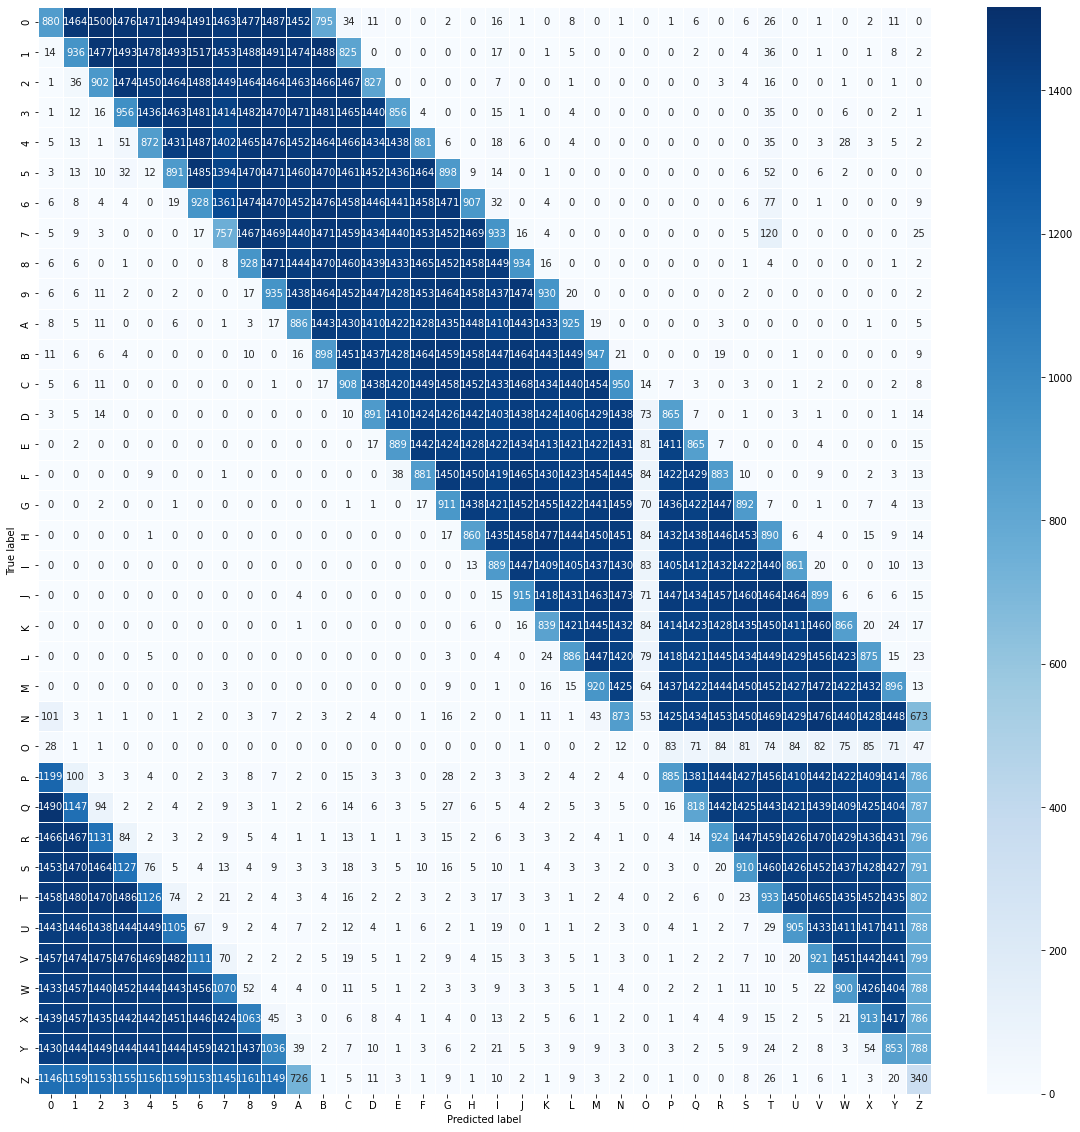

In [49]:
min_length = min(len(train_ground_truths), len(train_predictions))
train_ground_truths = train_ground_truths[:min_length]
train_predictions = train_predictions[:min_length]
cm = confusion_matrix(train_ground_truths, train_predictions)
labels_category = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# Set figure size (width, height) in inches
plt.figure(figsize=(20, 20))

sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, cmap='Blues', xticklabels= labels_category, yticklabels=labels_category)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### Calculate the evaluation matrix

In [50]:
average_val = 'macro'

accuracy = accuracy_score(train_ground_truths, train_predictions)
precision = precision_score(train_ground_truths, train_predictions, average=average_val)
recall = recall_score(train_ground_truths, train_predictions, average=average_val)
f1 = f1_score(train_ground_truths, train_predictions, average=average_val)

print(f"Accuracy: {round(accuracy * 100, 2)}%")
print(f"Precision: {round(precision * 100, 2)}%")
print(f"Recall: {round(recall * 100, 2)}%")
print(f"F1 Score: {round(f1 * 100, 2)}%")

Accuracy: 5.43%
Precision: 5.26%
Recall: 5.27%
F1 Score: 5.26%


### Testing Model

##### Set to evaluation mode

In [51]:
# Set the model to evaluation mode
model.eval()

# Keep track of the validation loss and accuracy
test_loss = 0.0
test_correct = 0
test_total = 0

##### Test the model

In [52]:
# Iterate over the validation dataset in batches
test_predictions = []
test_ground_truths = []

for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Update the validation loss
    test_loss += loss.item() * labels.size(0)

    test_predictions.extend(predicted.cpu().numpy())
    test_ground_truths.extend(labels.cpu().numpy())

    # Update the testing accuracy
    _, predicted = torch.max(outputs.data, 1)
    test_total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

# Compute the average testing loss and accuracy
test_loss /= len(test_set)
test_accuracy = 100 * test_correct / test_total

# Print the testing loss and accuracy
print(f'Testing loss: {test_loss:.4f}, accuracy: {test_accuracy:.2f}%')

Testing loss: 0.0061, accuracy: 99.94%


##### Calculate the confusion matrix

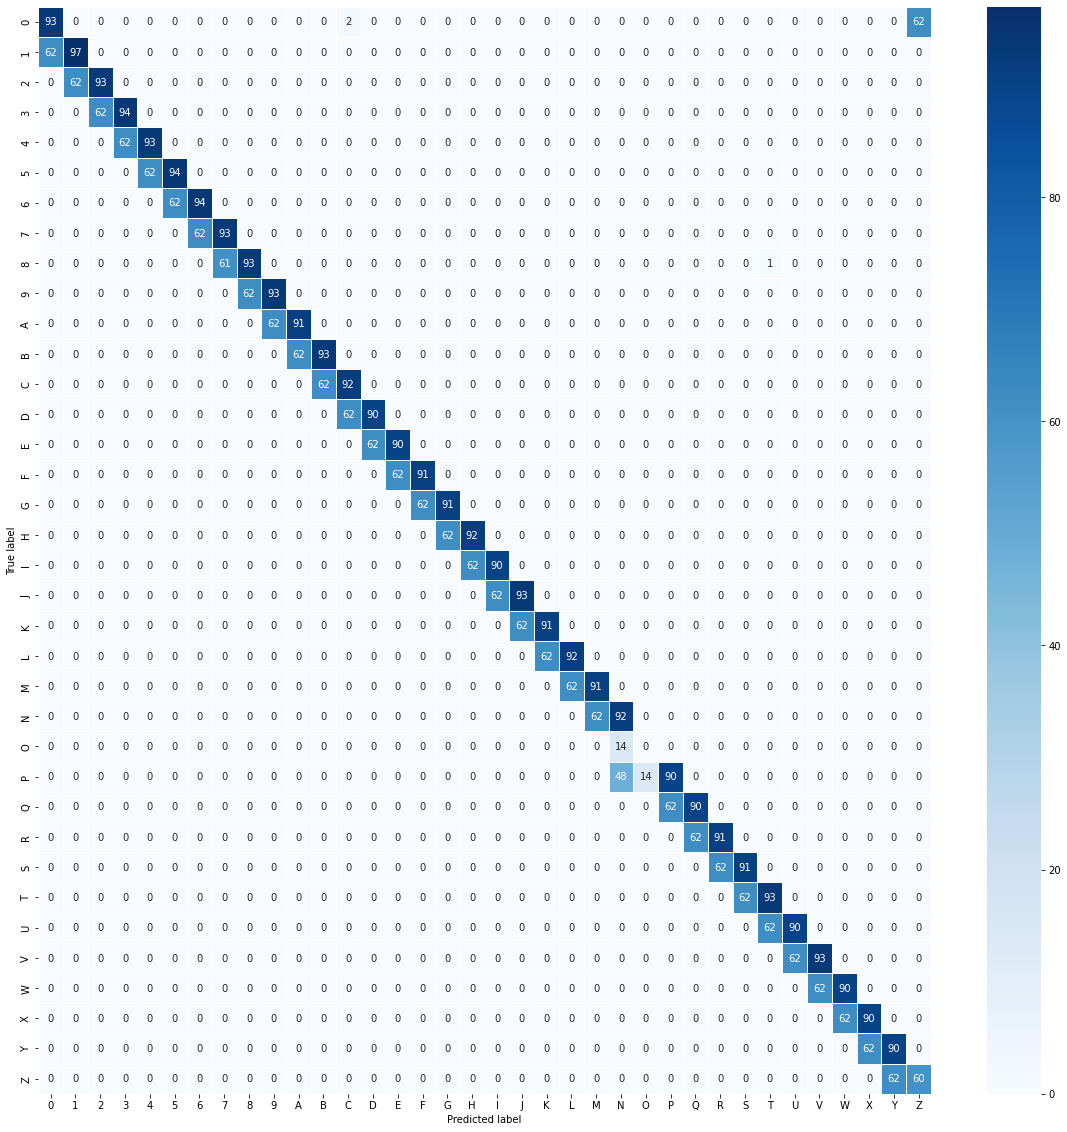

In [57]:
min_length = min(len(test_ground_truths), len(test_predictions))
test_ground_truths = test_ground_truths[:min_length]
test_predictions = test_predictions[:min_length]
# Calculate the confusion matrix
cm = confusion_matrix(test_ground_truths, test_predictions)
labels_category = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N','O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= labels_category, yticklabels=labels_category)

# Set figure size (width, height) in inches
plt.figure(figsize=(20, 20))

sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, cmap='Blues', xticklabels= labels_category, yticklabels=labels_category)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### Calculate the evaluation matrix

In [58]:
average_val = 'macro'

accuracy = accuracy_score(test_ground_truths, test_predictions)
precision = precision_score(test_ground_truths, test_predictions, average=average_val)
recall = recall_score(test_ground_truths, test_predictions, average=average_val)
f1 = f1_score(test_ground_truths, test_predictions, average=average_val)

print(f"Accuracy: {round(accuracy * 100, 2)}%")
print(f"Precision: {round(precision * 100, 2)}%")
print(f"Recall: {round(recall * 100, 2)}%")
print(f"F1 Score: {round(f1 * 100, 2)}%")

Accuracy: 59.29%
Precision: 57.73%
Recall: 57.73%
F1 Score: 57.73%


##### Save the model

In [ ]:
# Save the state_dict model to a file
torch.save(model.state_dict(), 'alexnet-letter-state-dict.pth')

# Save the model to a file
torch.save(model, 'alexnet-letter.pth')